# extract building outlines from a sentinel-2 image, using scikit-image.
### Skimage 
"scikit-image is a collection of algorithms for image processing. It is available free of charge and free of restriction. We pride ourselves on high-quality, peer-reviewed code, written by an active community of volunteers."
We will be analyzing how certain skimage functions work behind the scenes. We will do so by performing building outline extractions with multiple different methods and explaining the used functions. 




### we will go over:
    1. thresholding
  
      -color.rgb2gray

    -morphology.remove_small_objects
    


    2. canny edge detection
    
    -feature.canny
    


    3. thresholding+canny+contour
    
    -exposure.equalize_hist
    
    -morphology.remove_small_holes
    
    -measure.find_contours
    



## Dependancies 


In [47]:

import os
import skimage # a "collection of algorithms" we will be using today. 
import numpy as np #provides arrays that matplotlib uses often for image processing 
import geopandas as gpd 
import pandas as pd
import rasterio #processes raster images 
from rasterio import plot 
import matplotlib.pyplot as plt #this is used by skimages- will take the numpy arrays to plot them 
import skimage.io as io
from scipy import ndimage as ndi # the main package that skimages came from
from skimage.util import random_noise
from skimage import feature
import skimage.filters as filters
from skimage.feature import canny #canny edge detection


## Displaying our image
#### before we start
We will be working with .jp2 imagery which is commonly seen with the sentinel 2 satellite. where you see "rasterio.open("xxxxxxx"), replace the file I used with your own TCI (rgb) satellite image to follow along. 
MAKE SURE IT IS IN THE RIGHT PLACE, use  os.getcwd() to see where your computer will be looking when you call this method. 



#### To start, let's try displaying our image so we know what to work with.



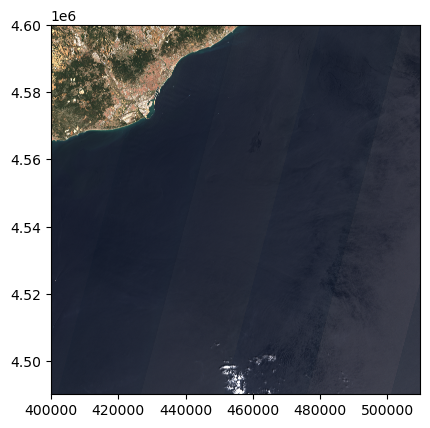

<Axes: >

In [48]:
rasterio.plot.show(rasterio.open('T31TDF_20230517T103629_TCI_10m.jp2'))

### ^ great, rasterio and QGIS will read the image just like this, they are able to take any image file type and understand what it means. let's see how skimages and matplotlib do when given an image.





In [49]:
#plt.imshow(rasterio.open('T31TDF_20230517T103629_TCI_10m.jp2'))
#plt.show()


### ^ if you run this code, you will see an error. 
not all packages read image data the same, we have to figure out a way for sk image to read our picture.
### how different packages read images
rasterio will translate image files itself and treats color bands as separate layers on top of providing functionality centered for GIS related processing. matplotlib takes images in the form of arrays and supports various color maps for customization. scikit-image extends off of matplotlib and automatically adjusts contrast, uses default color maps, and offers interactive exploration features within the displayed image.

### in simple terms:
  #### RASTERIO: 
  interprets the image itself and assumes RGB.
  #### matplotlib+skimage:
Displays ARRAYS assuming all are the package native colormap.
    
so now we know our issue, we have to translate our image into np arrays so we can use skimage.
### converting from jp2 to nparray
Numpy is used in close relation to all of the packages we used. As a result, rasterio has a .read function that converts image files into numpy arrays. 
Here, we can easily separate our color bands, let's see what color each one is by using rasterio and matplotlib. 


In [50]:
with rasterio.open('T31TDF_20230517T103629_TCI_10m.jp2') as opn: #referes to your image
    one = opn.read(1)  # Read the first band of the image
    two = opn.read(2) #seccond
    three = opn.read(3)#third 

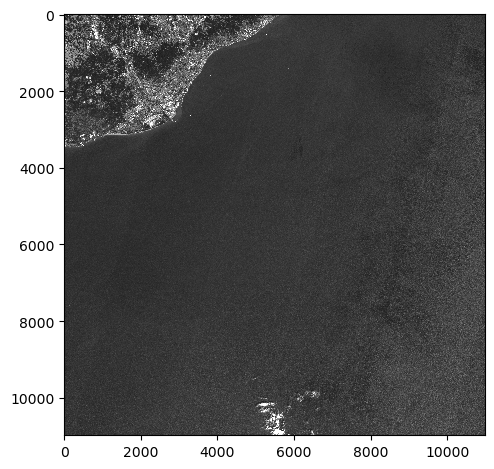

In [51]:
io.imshow(three) #supplement "three" with "one" and "two" to see the different layers.
io.show()

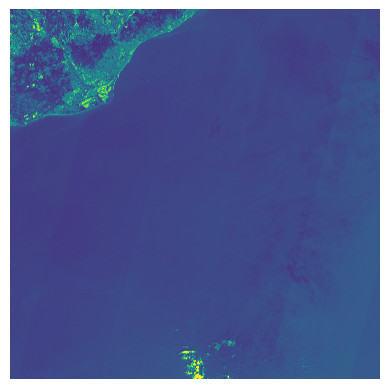

In [52]:
plt.imshow(three) #supplement "three" with "one" and "two" to see the different layers.
plt.axis('off')  # Optional: Turn off axis labels
plt.show()

### why do you think this is happening?
as stated earlier, these two packages assume all layers to be attributed to one color map. matplotlib assumes "viridis” as its default and skimage uses grayscale as its default. each library will read data differently, by restacking it, we can ensure we give them what we eat.

In other words, if you make skimages (and by association, matplotlib) read image bands directly from the file, the libraries will display the image with their default colormap. if you want them to understand the bands as RGB, you must feed it a numpy array in the form of (x pixels, y pixels, # bands)






### to resolve this.

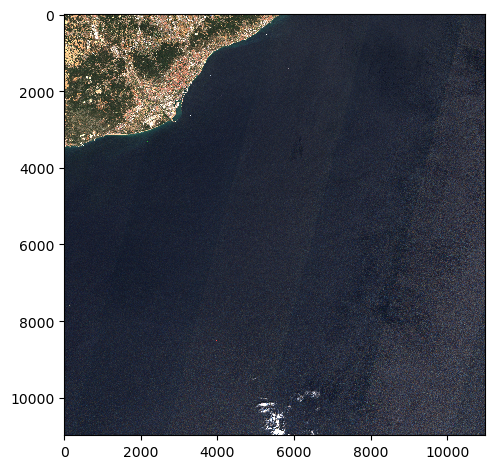

In [53]:


with rasterio.open('T31TDF_20230517T103629_TCI_10m.jp2') as src:
   #set each band to a variable 
    red = src.read(1, masked=True) 
    green = src.read(2, masked=True)
    blue = src.read(3, masked=True)

rgb_image = np.stack([red, green, blue], axis=-1) #restacking images 

io.imshow(rgb_image)# now skimage is reading a nparray and not a jp2
io.show()

### what happend
imagine a RGB image as a red green and blue image stacked on top of eachother with the dimensions of (x pixels, y pixels, bands). 
Here, we isolate each layer to a variable  and use np.stack to layer each on top of eachother. however we must set axis=-1 to keep the colors as the last dimension. (remove axis=-1 and see the error you get)

explanation aside, we did it! let's start using skimage.


## preparing our image
The image processing methods we will look at commonly rely on grayscale images to further define their edges. 

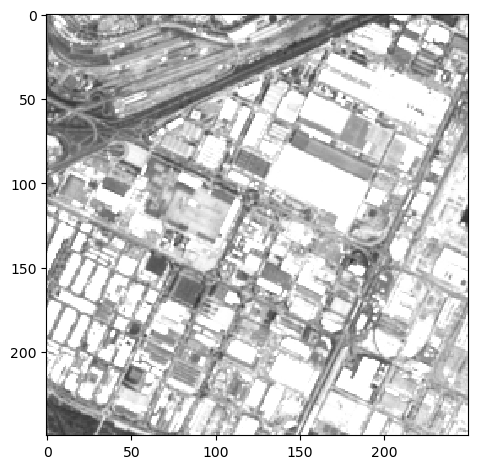

In [54]:
land = rgb_image[2250:2500, 2600:2850, :] #isolates the top corner of the image, a industrial zone of barsalona
grayland = skimage.color.rgb2gray(land) 
io.imshow(grayland)
io.show()

### Function explanation:
 Skimage's grayscale function works without any complex algorithms or equations, just off of human perception. 
for each pixel, it multiplies the magnitude of their red green and blue values to 0.2125, 0.7154, and 0.0721 respectively to find the intensity values for the grayscale image. 

This is simply done in one line of code:
RGB being the rgb image and coeffs being the unique weight values of RGB to display gray.

      return rgb @ coeffs




# 

# 1.thresholding 
This is an image processing method that takes the image's grayscale value range and calculates the intensity that has the foreground to one side and background to the other. by doing so, values above and below the threshold become whiter or blacker respectively. it's one of the easiest ways to use image processing to isolate objects.

This method comes with some issues however. you can't assume the same threshold value for every scenario as lighting can differ place to place. This can be solved by adaptive thresholding which thresholds an image chunk by chunk or by just picking other thresholding methods. On top of that, thresholding does not take into account the relationship of pixels and what you are trying to find. As a result, you just have to hope the target object is distinguishable by its grayscale value. This results in many errors with darker buildings and limitations in application. 

### here are examples of different thresholding methods
In this example we will be using triangle thresholding.
https://imagej.net/plugins/auto-threshold
The thresholding is done by finding many quantities through extensive calculations and using them to determine the optimal threshold. 

### Triangle Thresholding Breakdown
let:

hist be the histogram of the image.

arg_peak_height be the index of the peak value in the histogram.

arg_low_level be the index of the lowest gray level value in the histogram.

width be the width of the peak in the histogram.

x1 be the range of indices within the width of the peak.

y1 be the histogram values corresponding to x1.

peak_height be the normalized peak height.

length be the length calculated based on the peak height and width.

arg_level be the index of the threshold location.

#### length = peak_height * x1 - width * y1
#### arg_level = argmax(length) + arg_low_level

Keep in mind, this is very simplified as it excludes other distinguishable characteristics of this method such as the flipping of the histogram to detect optimal value ranges. 


 

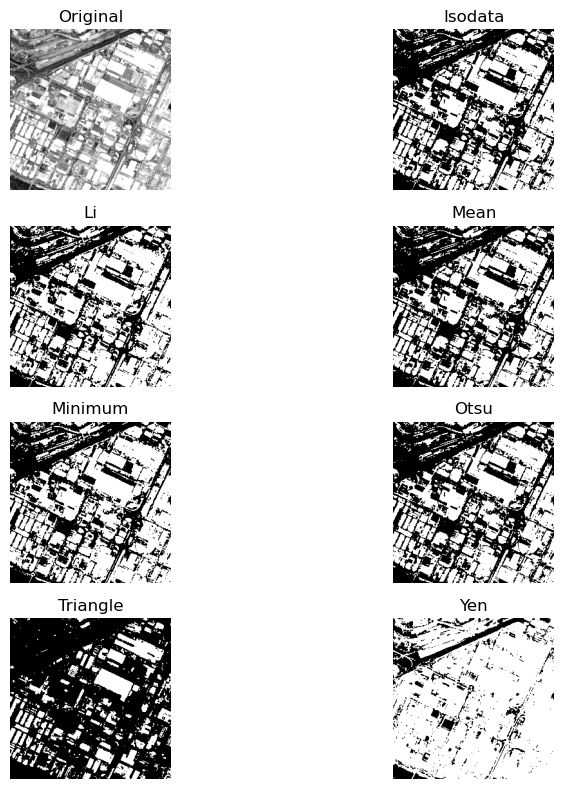

In [55]:
threshold_image = filters.threshold_triangle(grayland)
threshold_image

0.9795482100183823

### Now we have our threshold, aka the value that dictates fore and background.
To use this number, we run it through a logic gate. By doing so, we basically set the values that fit above said threshold to "true" while setting the rest to "false". 


In [56]:
# Convert the threshold image to binary
binary_image = np.bitwise_xor(grayland < threshold_image, True) 
binary_image

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True,  True,  True]])

congrats, we have our thresholded image; one issue though, how do we visualize true and false?

We do so by making our bool values binary numbers. lets normalize it and make it [0-1]. This is a vital step and will be seen very frequently when displaying data.





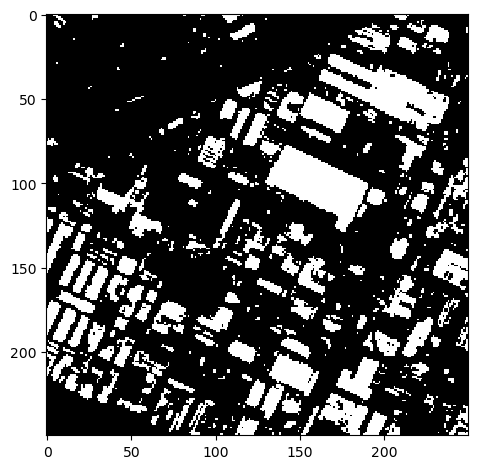

In [57]:
normalized_binary = binary_image.astype(float)
normalized_binary /= normalized_binary.max()
io.imshow(normalized_binary, cmap='gray')
io.show()


### great, but as you can tell, there are many image artifacts.
These are errors caused as a byproduct of your extraction methods. These can be resolved through pre/post processing or by just using better images. Let's do some simple post processing.
We will be using skimage's morphology functions. These are tools that manipulate the image based on its content. this different from skimage's filters as it has a more specialized task (many morphology methods require binary data in the form of bool or ints).





In [58]:

#removes small arifacts 
cleanfinal=skimage.morphology.remove_small_objects(binary_image, 21) #change 

### Function explanation:
If you observe the source code, this function works very simply. Omitting the error checks, this function works by:
1. taking binary array and size
2. making a array full of the connected 1 values (objects) using ndi.label if given a Bool array (skipped if give int array)
3. using np.bincount to figure out size of objects (groups of 1's)
4. creates a new mask array  that will set each object smaller than the threshold to 0
5. returns applied mask



We used one of many functions in skimages to manipulate images. this one in particular will remove any objects that are smaller than set size. adjust as needed. 

In [59]:


#normalize the image to ensure its [0-1], 
normalized_image = cleanfinal.astype(float)
normalized_image /= normalized_image.max()

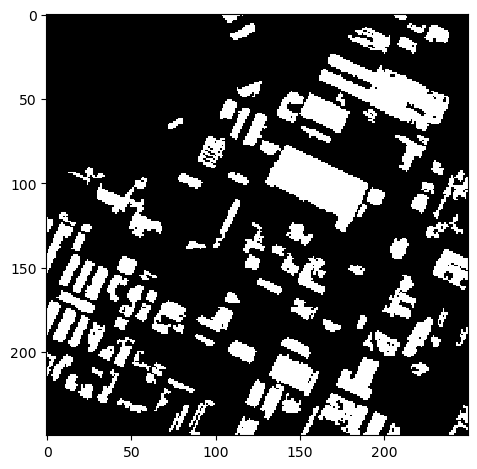

In [60]:
io.imshow(normalized_image, cmap='gray')
io.show()

### Final product
This is underwhelming. We exclusively used thresholding to explain the workflow. Typically, thresholding is used in preprocessing to simplify the image when more complex algorithms are used. Now that you know how thresholding works lets see more complex algorithms for edge detection in action.






## 2.Canny edge detection
Canny edge detector is an image processing algorithm.
https://en.wikipedia.org/wiki/Canny_edge_detector
https://scikit-image.org/docs/stable/auto_examples/edges/plot_canny.html

This is a collection of image processing algorithms that work in a coordinated order to detect edges: 

Noise Reduction: Guassian filter.

Gradient Calculation: Computing the gradient magnitude and direction of the smoothed image to identify what directions the edges are facing. 

Non-maximum Suppression: Nullifies false edges that don't align with the gradient. 

Double Thresholding: sorts edges based on their threshold and gradient level. 

Edge Tracking by Hysteresis: Connecting the weak edge pixels to strong edge pixels with the assumption noise caused siad disconnection. 



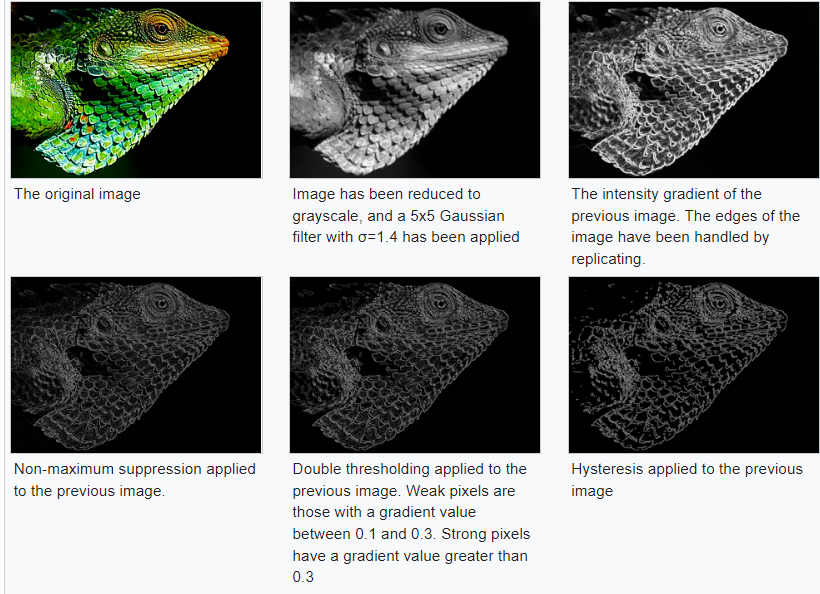

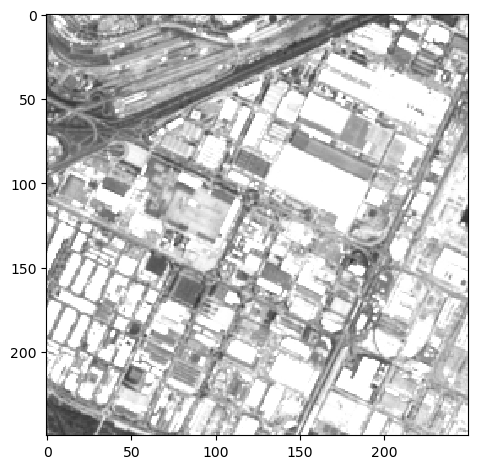

In [61]:
grayland=skimage.color.rgb2gray(land)
io.imshow(grayland)
io.show()

### Getting started.
Skiamages comes with its own canny function which will directly give us our building edges (and anything else it detects). Let's use it and dissect how it works.
the sigma value dictates the standard deviation of the gaussian filter, remember, canny is a aggregate of numerous algorithms working together, not just one.

instead of explaining how a change in sigma affects the image, we will show two examples with two different sigma values.







In [62]:

edges1 = feature.canny(grayland)
edges2 = feature.canny(grayland, sigma=2)
edges1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ..., False, False, False]])

once again, lets normalize it.

In [63]:
edges1 = edges1.astype(np.float32)  # Convert to float
edges1 /= edges1.max()  # Normalize to the range [0, 1]
edges2 = edges2.astype(np.float32)  # Convert to float
edges2 /= edges2.max()  # Normalize to the range [0, 1]

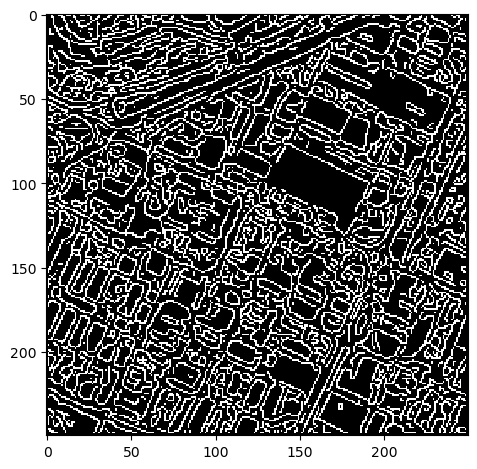

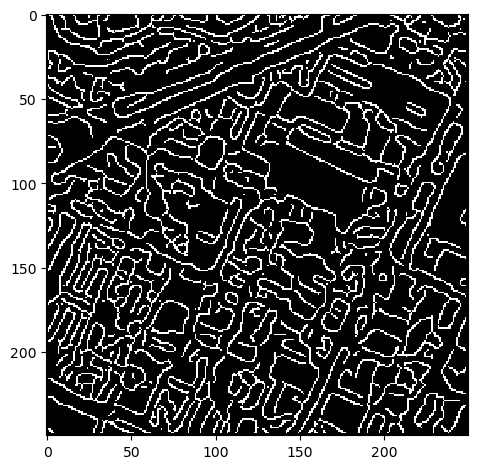

In [64]:
io.imshow(edges1, cmap='gray')
io.show()
io.imshow(edges2, cmap='gray')
io.show()

## 3.Contour

### Preprocessing

we will do a more thorough preprocessing method for our image. Let's see if we can make our image as simple as possible.
To do so, we will now be using thresholding and canny edge detector as preprocessing steps instead of the main method of defining edges (alongside other tools). 


In [65]:

import skimage.color #color band minipulation
from skimage import feature, morphology, measure, draw


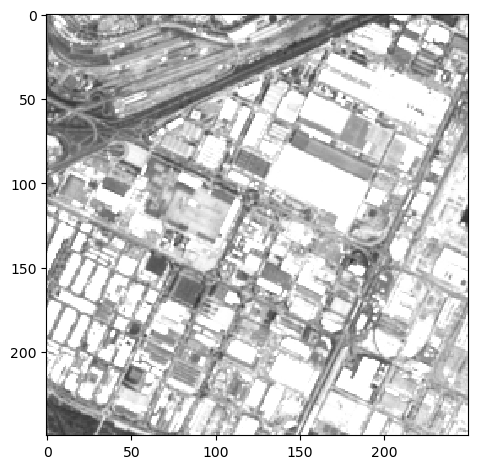

In [66]:
pic=skimage.color.rgb2gray(land)
io.imshow(pic)
io.show()

### Equalize
Our first preprocessing step after rescaling is histogram equalization. This spreads out the intensity values in our histogram so we get greater contrast.



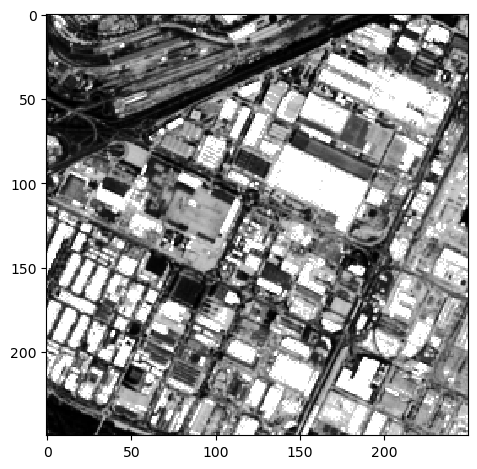

In [67]:
gray_image = skimage.exposure.equalize_hist(pic) 
io.imshow(gray_image)
io.show()

### Function explanation:

 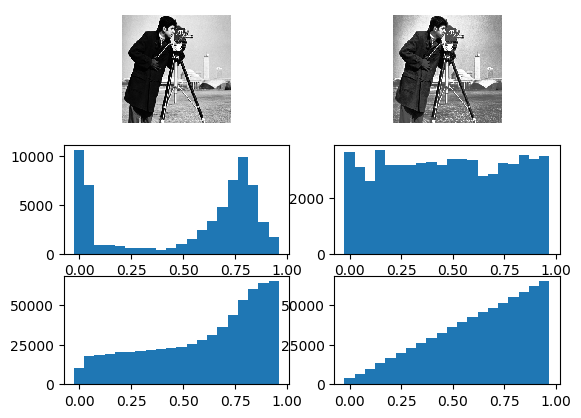
 
http://www.janeriksolem.net/histogram-equalization-with-python-and.html
This is where skimage derived their function from. The purpose of the function is to normalize the intensity values by making the histogram as even as possible.
It normalizes values using the cumulative distribution function.
 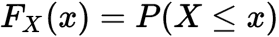

### thresholding
Our second step is using thresholding. We will not be using triangle as it is very aggressive and is too extreme for a preprocessing step. let's use mean_thresholding which references the average of gray values and not the range.




In [68]:

threshold = skimage.filters.threshold_mean(gray_image) #this method useses the mean of values to find the threshold
threshold

0.5178508231974882

In [69]:
gray_image = gray_image > threshold #sets values of gray_image that are above threshold to true.
gray_image

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

Now we have our equalized and thresholded image as gray_image, let's see how it looks now.



In [70]:
prepared_pic = gray_image.astype(float)#converts to numbers
prepared_pic /= prepared_pic.max()
prepared_pic

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

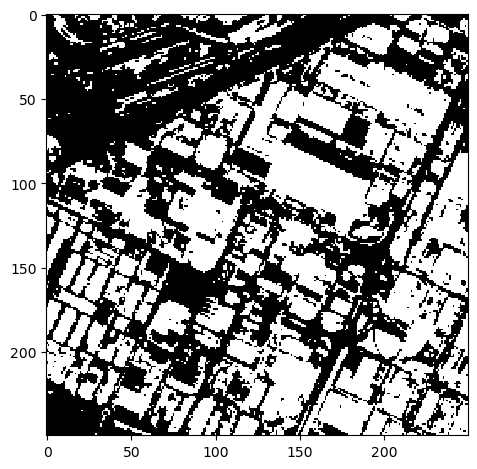

In [71]:
io.imshow(prepared_pic)
io.show()

### more preprocessing
Now we have done: grayscale-> histogram equalization-> thresholding. 
Our third step in preprocessing is to use skimage's morphology methods to clean up our image. we have lots of artifacts in the form of random detections and peppers/holes in our outlines. 




In [72]:
gray_image1=skimage.morphology.remove_small_objects(gray_image, 20) #change 

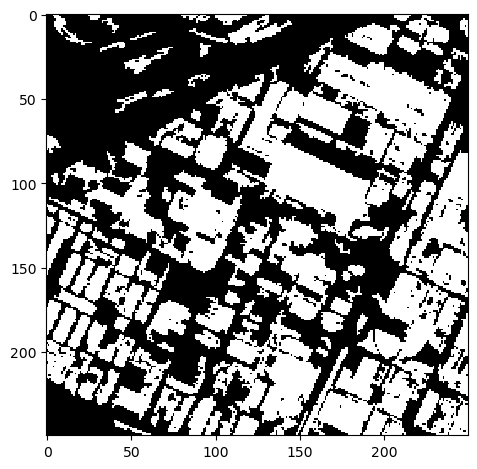

In [73]:
prepared_pic1 = gray_image1.astype(float)#converts to numbers
prepared_pic1 /= prepared_pic1.max()
io.imshow(prepared_pic1)
io.show()

### artifact removal
We used skimage's morphology tools to remove the small white detections but we still have holes in the ones that stayed.








In [74]:
gray_image2=skimage.morphology.remove_small_holes(gray_image1, 14) #adjust as needed

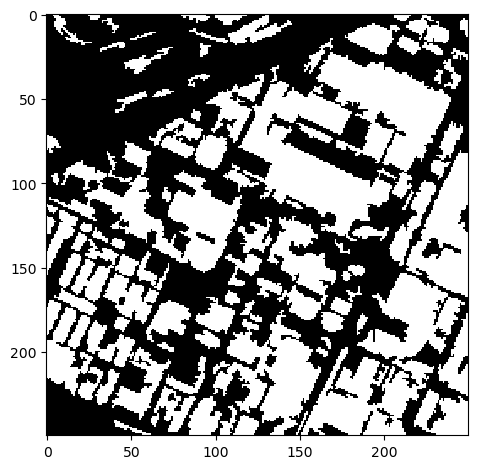

In [75]:
prepared_pic2 = gray_image2.astype(float)#converts to numbers
prepared_pic2 /= prepared_pic2.max()
io.imshow(prepared_pic2)
io.show()

### Function explanation:
The remove_small_holes function works just like the remove_small_object function but with opposite values. 



# fourth step
now, we have our buildings. lets find their edges with canny edge detector.


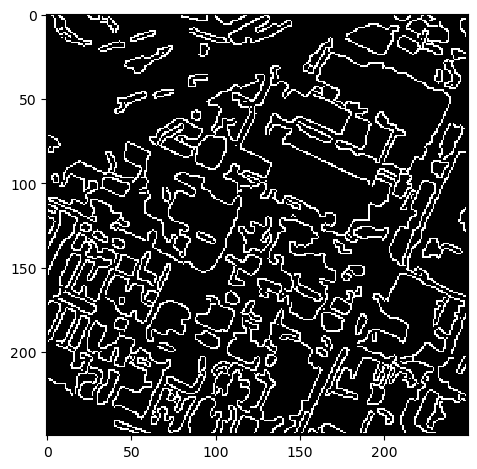

In [76]:
edges = skimage.feature.canny(prepared_pic2, sigma=1.0)
edges = edges.astype(np.float32)  # Convert to float
edges /= edges.max()  # Normalize to the range [0, 1]
io.imshow(edges)
io.show()

### processing
Now that we have ur building edges, lets find the contours; Contours are the continouis boundries of an object or shape. 

In [77]:
contours = skimage.measure.find_contours(edges)


### Function explanation:
find_contour uses the marching squares algorithm to detect contours and implements the assemble_contour helper method to connect them. The marching square algorithm essentially breaks down the image into 2x2 squares to assign contours from a case table. Then, the values are run through linear interpolation to find a more accurate position for the contour.




### postprocessing
now our main image processing methods are done, lets see our final result.

In [78]:
overlay = land.copy() #we will set the RGB image as our backround

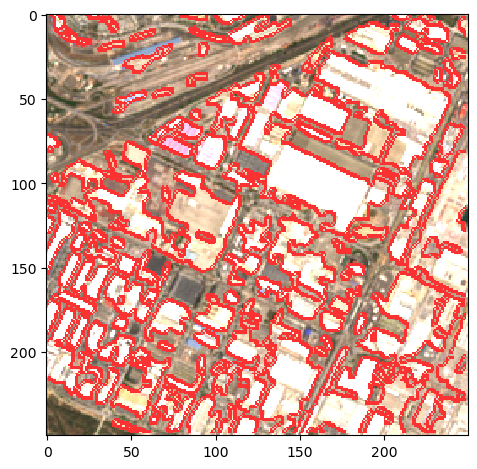

In [79]:


#for contour in contours:
   # rr, cc = skimage.draw.polygon_perimeter(contour[:, 0], contour[:, 1], overlay.shape[:2])
    #overlay[rr, cc] = [250, 50,50]  


#io.imshow(overlay)
#io.show()
for contour in contours:
    rr, cc = contour[:, 0].astype(int), contour[:, 1].astype(int)
    overlay[rr, cc] = [250, 50, 50]

# Display the overlay image
io.imshow(overlay)

io.show()

We can simplify the process by not using canny and just finding contours of the thresholded image.

In [80]:
contours = skimage.measure.find_contours(gray_image2)
#contours

In [81]:
overlay = land.copy()

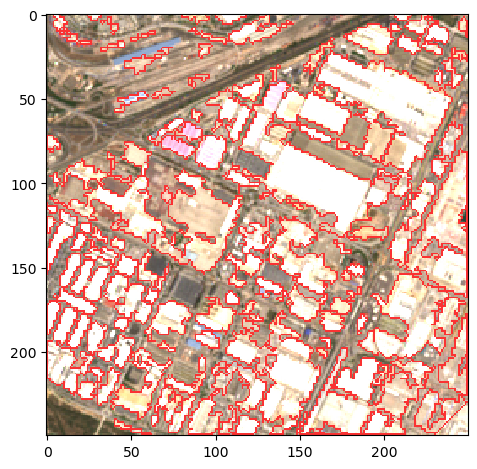

In [82]:


for contour in contours:
    rr, cc = skimage.draw.polygon_perimeter(contour[:, 0], contour[:, 1], overlay.shape[:2])
    overlay[rr, cc] = [250, 50,50]  


io.imshow(overlay)
io.show()
